In [ ]:
!nvidia-smi

Fri Feb 12 19:01:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, datasets
import torch.optim as optim

import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [ ]:
print(torch.__version__)

1.7.0+cu101


# **Model**

In [ ]:
# Model
class Siamese_Net(nn.Module):
  def __init__(self):
    super(Siamese_Net,self).__init__()

    self.conv1=nn.Conv2d(1,64,10)
    self.conv2=nn.Conv2d(64,128,7)
    self.conv3=nn.Conv2d(128,128,4)
    self.conv4=nn.Conv2d(128,256,4)

    self.Linear1=nn.Linear(9216,4096)
    self.flatten=nn.Flatten()
    self.Linear2=nn.Linear(4096,1)

    self.relu=nn.ReLU()
    self.maxP=nn.MaxPool2d(2)
    self.sigm=nn.Sigmoid()

    # self.initialize_weights()

  def twin(self,x):

    out=self.conv1(x)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv2(out)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv3(out)
    out=self.relu(out)
    out=self.maxP(out)

    out=self.conv4(out)
    out=self.relu(out)

    # test=out.view(out.size()[0], -1)
    out=self.flatten(out)
    # print(test==out) ##result -> true

    out=self.Linear1(out)
    out=self.sigm(out)

    return out

  def forward(self,x1,x2):

    x1_out=self.twin(x1)
    x2_out=self.twin(x2)

    # score= linear(distance between vectors)
    score=self.Linear2(torch.abs(x1_out-x2_out))

    # print(score)
    
    return score

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,0,1e-2)
        nn.init.normal_(m.bias, 0.5, 1e-2)
      if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight,0,2e-2)
        nn.init.normal_(m.bias, 0.5, 1e-2)



In [ ]:
#testing
net=Siamese_Net()
# print(net)
dummyx1=torch.randn(64,1,105,105)
dummyx2=torch.randn(64,1,105,105)
o=net(dummyx1,dummyx2)
print(o.shape)

torch.Size([64, 1])


# **Omniglot Dataset**

In [ ]:
# download the dataset
omni_train=datasets.Omniglot(root='/content', 
                       background= True,  
                       download = True
                       )

omni_test=datasets.Omniglot(root='/content', 
                       background= False,  
                       download = True
                       )

Extracting /content/omniglot-py/images_background.zip to /content/omniglot-py



Extracting /content/omniglot-py/images_evaluation.zip to /content/omniglot-py



In [ ]:
# Omniglot dataset- didnt rename cause would have had to rename it everywhere
class Face_Dataset(Dataset):
  def __init__(self,root_dir, job='train',ways=10,transform=None):
    super(Face_Dataset,self).__init__()
    self.root_dir=root_dir
    self.job=job
    self.all_classes=os.listdir(root_dir)
    self.num_classes=len(self.all_classes)
    self.face_list, self.number_of_faces=self.get_char_list()
    self.ways=ways
    self.transform=transform
    print(self.all_classes)

  def __len__(self):
    return self.number_of_faces

  def __getitem__(self,idx):
    if self.job=='train':
      is_Same=1
      # Same person if even
      if idx%2==0:
        path_img_1,path_img_2,_=self.get_same()
      # different people 
      else:
        is_Same=0
        path_img_1,path_img_2=self.get_different()

      img1=Image.open(path_img_1).convert('L')
      img2=Image.open(path_img_2).convert('L')
      
      if self.transform:
        img1=self.transform(img1)
        img2=self.transform(img2)

      return img1,img2,torch.tensor([is_Same], dtype=torch.float32)

    else:
      img_list=[]
      ways=self.ways

      # grab two images from the same class
      path_img_1,path_img_2,id_to_avoid=self.get_same()
      img_list+=[path_img_1,path_img_2]

      ways=(ways-2)//2

      # and remaining from different classes
      for i in range(ways):
        img_list+=self.get_different(id_to_avoid)

      for i in range(len(img_list)):
        img=Image.open(img_list[i]).convert('L')
        if self.transform:
          img=self.transform(img)
        img_list[i]=img

      img_list_tensor=torch.stack(img_list)
      return img_list_tensor

  def get_char_list(self) -> (dict, int):
      a_list,n_letters={},0
      for idx, alpha in enumerate(self.all_classes):
        a_list[idx]=[]
        for char in os.listdir(os.path.join(self.root_dir,alpha)):
          l_list=[]
          for letter in os.listdir(os.path.join(self.root_dir,alpha,char)):
            l_list.append(os.path.join(self.root_dir,alpha,char,letter))
            n_letters+=1
          a_list[idx].append(l_list)
      return a_list,n_letters

  def get_same(self) -> (str, str, int):
    alpha_id=random.randint(0,self.num_classes-1)
    char_id=random.randint(0,len(self.face_list[alpha_id])-1)
    path_img_1=random.choice(self.face_list[alpha_id][char_id])
    path_img_2=random.choice(self.face_list[alpha_id][char_id])
    return path_img_1,path_img_2,char_id

  def get_different(self, avoid=None)-> (str, str):

    alpha_id_1=random.randint(0,self.num_classes-1)
    char_id_1=random.randint(0,len(self.face_list[alpha_id_1])-1)
    while char_id_1==avoid:
      char_id_1=random.randint(0,len(self.face_list[alpha_id_1])-1)

    alpha_id_2=random.randint(0,self.num_classes-1)
    char_id_2=random.randint(0,len(self.face_list[alpha_id_2])-1)
    while char_id_2==char_id_1 or char_id_2==avoid:
      char_id_2=random.randint(0,len(self.face_list[alpha_id_2])-1)

    path_img_1=random.choice(self.face_list[alpha_id_1][char_id_1])
    path_img_2=random.choice(self.face_list[alpha_id_2][char_id_2])
    return path_img_1,path_img_2
      

In [ ]:
a=torch.randn((64,3,122,450),dtype=torch.float32)
b=torch.randn((64,3,122,450),dtype=torch.float32)
c=torch.randn((64,3,122,450),dtype=torch.float32)
l=[a,b,c]
lt=torch.stack(l)
print(lt.shape)
print(lt[0,:].shape)

torch.Size([3, 64, 3, 122, 450])
torch.Size([64, 3, 122, 450])


In [ ]:
# omniglot root
train_root='/content/omniglot-py/images_background'
val_root='/content/omniglot-py/images_evaluation'
batch_size=16
ways=10

In [ ]:
# Omniglot Calculating the mean and std of the data

def find_mean_std(datasets,batch_s=1):
  
  means_stds=[]
  for dataset in datasets:
    to_norm_loader=DataLoader(dataset=dataset, batch_size=batch_s)
    print('Total number of samples: ', len(dataset))

    # #run for 1 batch 
    # data_iter=iter(to_norm_loader)
    # img,_,__=data_iter.next()
    # print(img.shape)
    
    channels_sum, channels_squared_sum, num_batches=0, 0, 0
    for img,_,__ in to_norm_loader:
      # print(img.shape)#[batch,C,H,W]
      channels_sum+=torch.mean(img,dim=[0,2,3])
      channels_squared_sum+=torch.mean(img**2,dim=[0,2,3])
      num_batches+=1
    
    mean=channels_sum/num_batches
    std=(channels_squared_sum/num_batches- mean**2)**0.5
    means_stds.append(mean)
    means_stds.append(std)
  return means_stds

to_be_norm_dataset=Face_Dataset(train_root, transform=transforms.Compose([
                                                             transforms.Resize((105,105)),
                                                             transforms.ToTensor()
                                           ]))

to_be_norm_dataset_val=Face_Dataset(val_root, transform=transforms.Compose([
                                                             transforms.Resize((105,105)),
                                                             transforms.ToTensor()
                                           ]))

mean, std,mean_val,std_val= find_mean_std([to_be_norm_dataset, to_be_norm_dataset_val], batch_s=batch_size)

print(f'mean: {mean.item()}    std: {std.item()}     val mean: {mean_val.item()}    val std: {std_val.item()}')

['Syriac_(Estrangelo)', 'Tagalog', 'Asomtavruli_(Georgian)', 'Hebrew', 'Sanskrit', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Cyrillic', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Korean', 'Armenian', 'Bengali', 'Gujarati', 'Mkhedruli_(Georgian)', 'Arcadian', 'Anglo-Saxon_Futhorc', 'Latin', 'Futurama', 'Grantha', 'Tifinagh', 'Japanese_(katakana)', 'N_Ko', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Burmese_(Myanmar)', 'Alphabet_of_the_Magi', 'Greek', 'Japanese_(hiragana)', 'Balinese', 'Braille', 'Malay_(Jawi_-_Arabic)', 'Early_Aramaic']
['Avesta', 'Old_Church_Slavonic_(Cyrillic)', 'Sylheti', 'Tengwar', 'Atemayar_Qelisayer', 'Mongolian', 'Glagolitic', 'Syriac_(Serto)', 'Oriya', 'Kannada', 'Angelic', 'Tibetan', 'Malayalam', 'Keble', 'Ge_ez', 'Gurmukhi', 'Aurek-Besh', 'ULOG', 'Atlantean', 'Manipuri']
Total number of samples:  19280
Total number of samples:  13180
mean: 0.9244393110275269    std: 0.26429393887519836     val mean: 0.9171667695045471    val std: 0.27562999725341797


In [ ]:
# prepare datasets(OMNIGLOT)

transform=transforms.Compose([
                              transforms.Resize((105,105)),
                              transforms.RandomAffine(30,shear=0.2),
                              transforms.ToTensor(),
                              transforms.Normalize([mean.item()],[std.item()]),
])
# dataset=Face_Dataset(root,transform=transform)
dataset_train=Face_Dataset(train_root, transform=transform)
dataset_val=Face_Dataset(val_root,job='val', ways=ways, transform=transforms.Compose([transforms.Resize((105,105)),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize([mean_val.item()],[std_val.item()])
                                                            ])
)

dataloader_train=DataLoader(dataset=dataset_train, batch_size=batch_size)
dataloader_val=DataLoader(dataset=dataset_val, batch_size=batch_size)


['Syriac_(Estrangelo)', 'Tagalog', 'Asomtavruli_(Georgian)', 'Hebrew', 'Sanskrit', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Cyrillic', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Korean', 'Armenian', 'Bengali', 'Gujarati', 'Mkhedruli_(Georgian)', 'Arcadian', 'Anglo-Saxon_Futhorc', 'Latin', 'Futurama', 'Grantha', 'Tifinagh', 'Japanese_(katakana)', 'N_Ko', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Burmese_(Myanmar)', 'Alphabet_of_the_Magi', 'Greek', 'Japanese_(hiragana)', 'Balinese', 'Braille', 'Malay_(Jawi_-_Arabic)', 'Early_Aramaic']
['Avesta', 'Old_Church_Slavonic_(Cyrillic)', 'Sylheti', 'Tengwar', 'Atemayar_Qelisayer', 'Mongolian', 'Glagolitic', 'Syriac_(Serto)', 'Oriya', 'Kannada', 'Angelic', 'Tibetan', 'Malayalam', 'Keble', 'Ge_ez', 'Gurmukhi', 'Aurek-Besh', 'ULOG', 'Atlantean', 'Manipuri']


# Check if the datasets are working

0.0
torch.Size([1, 105, 105]) 
 torch.Size([1, 105, 105])
(105, 105) 
 (105, 105)


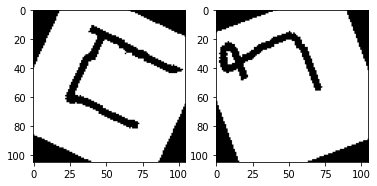

In [ ]:
# Testing train Dataset
img1,img2,are_Same=dataset_train[1]

print(are_Same.item())
print(img1.shape,'\n',img2.shape)

# convert to PIL and multiply with std and add mean to un-normalize the images for viewing purposes only
show_img1=transforms.ToPILImage()(img1.mul_(std).add_(mean))
show_img2=transforms.ToPILImage()(img2.mul_(std).add_(mean))

print(show_img1.size,'\n',show_img2.size)

plt.subplot(121)
plt.imshow(show_img1,cmap='gray')

plt.subplot(122)
plt.imshow(show_img2,cmap='gray')


torch.Size([10, 1, 105, 105]) torch.Size([1, 105, 105])


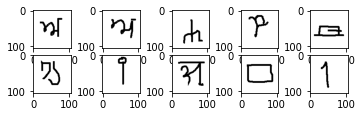

In [ ]:
# Testing validation Dataset
imgs=dataset_val[0]

print(imgs.shape, imgs[0,:].shape)

# data_iter=iter(dataloader_val)
# images=data_iter.next()
# print(images.shape) #torch.Size([16, 10, 1, 105, 105])

for i in range(ways):
  img=imgs[i,:]
  plt.subplot(5,5,(i+1))
  plt.imshow(transforms.ToPILImage()(img.mul_(std_val).add_(mean_val)), cmap='gray')


# Training

In [ ]:
# change to True if you are resuming(Make sure to set the path for checkpoint in the next cell)
resume_training=False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=Siamese_Net().to(device)

loss_function=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=3e-4,weight_decay=6e-5)

# lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)
# lr_scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, verbose=True)

start_epoch=0
epochs=80

if resume_training:
  checkpoint = torch.load('/content/drive/MyDrive/dataset/ckpts_newest_2/checkp60.pt')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  # loss_function = checkpoint['loss']

In [ ]:
# Train Network

t_loss,accuracy=[],[]
val_every=1
save_every=20

for epoch in range(start_epoch, epochs+1):
  t_loss_batch=[]
  
  # ----------------------training---------------------------------------------
  model.train()
  for batch_idx, (img1, img2, isSame) in enumerate(dataloader_train):
    # Get data to cuda if possible
    img1, img2, isSame= img1.to(device),img2.to(device),isSame.to(device)

    # forward
    scores = model(img1, img2)
    loss = loss_function(scores, isSame)
    
    # backward
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

    t_loss_batch.append(loss.item())
  
  mean_loss=sum(t_loss_batch)/len(t_loss_batch)
  t_loss.append(mean_loss)
  # ------------------------lr scheduler---------------------------------------------
  
  # for ExponentialLR 
  # lr_scheduler.step()
  
  # forReduceLROnPlateau
  # lr_scheduler.step(mean_loss)
  
  # -----------------------------Validation----------------------------------
  if epoch%val_every==0:
    model.eval()
    with torch.no_grad():
      batch_accuracy=[]
      for batch_idx,images in enumerate(dataloader_val):
        score_l,correct=[],0
        images=images.to(device)
        img1=images[:,0,:]

        for i in range(1,ways):
          score=torch.sigmoid(model(img1,images[:,i,:]))
          score_l.append(score)

        scores=torch.stack(score_l)

        results=torch.argmax(scores,0)

        for i in range(results.shape[0]):
          if results[i,:].item()==0:
            correct+=1

        total=images.shape[0]
        batch_accuracy.append(correct/total)

      # finding the accuracy of that epoch
      accuracy.append(sum(batch_accuracy)/len(batch_accuracy))
    print(f'Epoch No.:{epoch} training loss:{t_loss[-1]}  validation accuracy:{accuracy[-1]*100}%')
  
  if epoch%save_every==0:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': t_loss[-1],
            }, f'/content/drive/MyDrive/dataset/ckpts_newest_2/checkp{epoch}.pt')
    

Epoch No.:0 training loss:0.5440679761136716  validation accuracy:35.601233818770226%
Epoch No.:1 training loss:0.42466475372492524  validation accuracy:56.15645226537217%
Epoch No.:2 training loss:0.33989964011917473  validation accuracy:64.07261326860841%
Epoch No.:3 training loss:0.27276568755940284  validation accuracy:69.8801577669903%
Epoch No.:4 training loss:0.2383774647079563  validation accuracy:68.25697815533981%
Epoch No.:5 training loss:0.20758283329331528  validation accuracy:74.49686488673139%
Epoch No.:6 training loss:0.1947164806394347  validation accuracy:78.65594660194175%
Epoch No.:7 training loss:0.17620207666114157  validation accuracy:81.67728559870551%
Epoch No.:8 training loss:0.1689928356619915  validation accuracy:79.87965210355988%
Epoch No.:9 training loss:0.16239056748828823  validation accuracy:81.81128640776699%
Epoch No.:10 training loss:0.15045524757139045  validation accuracy:81.54581310679612%
Epoch No.:11 training loss:0.1451956426937334  validation

Mean Loss: 0.107


Text(0, 0.5, 'Loss')

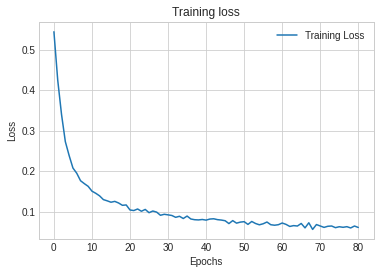

In [ ]:
# Training loss graph
print(f'Mean Loss: {sum(t_loss)/len(t_loss):.3f}')
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax = plt.axes()
ax.plot(t_loss,label='Training Loss')
# ax.plot(v_loss,label='Validation Loss')
ax.legend()
ax.set_title('Training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

Mean Accuracy: 86.420%
0.9168689320388349


Text(0, 0.5, 'Accuracy')

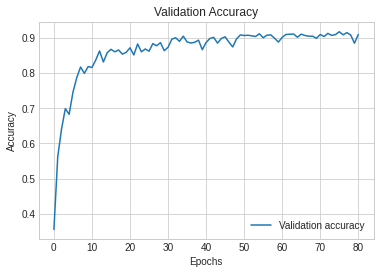

In [ ]:
# Accuracy graph
print(f'Mean Accuracy: {sum(accuracy)/len(accuracy)*100:.3f}%')
print(max(accuracy))
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.plot(accuracy,label='Validation accuracy')
# ax.plot(v_loss,label='Validation Loss')
ax.legend()
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

In [ ]:
# training accuracy for Omniglot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=Siamese_Net().to(device)
checkpoint = torch.load('/content/drive/MyDrive/dataset/ckpts_newest_2/checkp80.pt')
model.load_state_dict(checkpoint['model_state_dict'])

ways=10

dataset_train_acc=Face_Dataset(train_root,job='val', ways=ways,transform=transforms.Compose([
                                                                                             transforms.Resize((105,105)),
                                                                                             transforms.ToTensor(),
                                                                                             transforms.Normalize([mean.item()],[std.item()])
                                                                                             ]
))

dataloader_train_acc=DataLoader(dataset=dataset_train_acc, batch_size=batch_size)

# finding accuracy
model.eval()
with torch.no_grad():
  batch_accuracy=[]
  for batch_idx,images in enumerate(dataloader_train_acc):
    score_l,correct=[],0
    images=images.to(device)
    img1=images[:,0,:]

    for i in range(1,ways):
      score=torch.sigmoid(model(img1,images[:,i,:]))
      score_l.append(score)

    scores=torch.stack(score_l)

    results=torch.argmax(scores,0)

    for i in range(results.shape[0]):
      if results[i,:].item()==0:
        correct+=1

    total=images.shape[0]
    batch_accuracy.append(correct/total)
  print(f'Training accuracy: {sum(batch_accuracy)/len(batch_accuracy)*100:.3f}%')

['Syriac_(Estrangelo)', 'Tagalog', 'Asomtavruli_(Georgian)', 'Hebrew', 'Sanskrit', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Cyrillic', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Korean', 'Armenian', 'Bengali', 'Gujarati', 'Mkhedruli_(Georgian)', 'Arcadian', 'Anglo-Saxon_Futhorc', 'Latin', 'Futurama', 'Grantha', 'Tifinagh', 'Japanese_(katakana)', 'N_Ko', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Burmese_(Myanmar)', 'Alphabet_of_the_Magi', 'Greek', 'Japanese_(hiragana)', 'Balinese', 'Braille', 'Malay_(Jawi_-_Arabic)', 'Early_Aramaic']
Training accuracy: 98.449%
